# Neural networks : Echo State Network

## A brief introduction

<p style="text-align:justify">Since Frank Rosenblatt first created the perceptron in 1957, numerous neural models have surfaced. An <i>echo state network</i> is a Recurrent Neural Network (i.e., where the path may not be linear, allowing the network to have a memory) whose reservoir contains randomly generated neurons. Only the output weights (between the reservoir and the output) can be modified, through supervised learning : we can compare the network output to a « target » output. In this notebook, we will focus on an ESN model developped by Mantas Lukoševičius.</p>

In [15]:
%matplotlib inline

## Module importation

We'll first import the modules we need. We will need the <i>%matplotlib inline</i> command, which allows to plot graphs directly into the notebook, and the modules <b>numpy</b> (numerical module allowing vectors and matrix handling), <b>matplotlib</b> (which will plot graphs), <b>scipy</b> (whose linalg method will allow the importation of linear algebra functions), and <b>IPython</b> widgets, allowing to interact in real time with the graphs by moving cursors.

In [16]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
by Mantas Lukoševičius 2012
http://minds.jacobs-university.de/mantas
---
Modified by Xavier Hinaut: 2015-2016
http://www.xavierhinaut.com
"""
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *

## Random reset

We will initiate a first pseudo-random value, depending on the current time when launching the algorithm. This will allow to ensure that two different launchs of the program will not give the same results.

In [17]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

## Creating a "Network" class

We create a <i>Network</i> class. When initialized, an object from this class will have 4 default attributes :

<ul><li><b>initLen</b> : number of initializing iterations. During this phase, nothing happens: this allows to start the training with an intermediate value, rather than one of the first given values;;</li>
<li><b>trainLen</b> : number of training iterations. The network changes the weights between the reservoir and the output, so that it can predict or generate a series;</li>
<li><b>testLen</b> : number of testing iterations;</li>
<li><b>data</b> : data file. Here, the file contains the first 10'000 iterations of a Mackey-Glass chaotic series. A chaotic series is a series of numbers provided by a function, for which a small alteration of the origin number can have drastic consequences on the following terms.</li></ul>

The default number of neurons contained in the reservoir is 300 (<b>resSize</b>), while the input and the output contain both one neuron (<b>inSize and outSize</b>). The network can be represented like this : <img src="Reservoir.png"></img>

<p style="text-align:justify">Input neurons are connected to reservoir neurons. We save the weights of every connection in a <b style="color:#99cc00">W<sub>in</sub></b> matrix (dim. inSize x resSize). Weights of the connections from reservoir to the output are saved in the <b style="color:#ff0000">W<sub>out</sub></b> matrix (dim. resSize x outSize). Into the reservoir itself, one neuron is linked to every other : weights are saved in the <b style="color:#ffcc00">W</b> matrix (dim. resSize x resSize).</p>

<p style="text-align:justify">Values of the reservoir's neurons are saved in a <b style="color:#ffcc00">x</b> matrix (dim. resSize × 1). <b style="color:#00baff">X</b> matrix contains bias (<b style="color:#99cc00">1</b>), input (<b style="color:#99cc00">u</b>) and reservoir's neurons (<b style="color:#ffcc00">x</b>) values, over time (t). This matrix has a (1+inSize+resSize)×(trainLen-initLen) dimension. Finally, we save the ouput neuron values over time in a <b style="color:#ff0000">y</b> matrix (dim. 1×(trainLen-initLen)).</p>

<p style="text-align:justify"><b style="color:#a7008a">Y<sub>target</sub></b> matrix represents the « target » values. It matches the <b>data</b> values after initialization and training lengths. Those values will then be compared to the reservoir's output values.</p>

In [18]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen
        self.trainLen = trainLen
        self.testLen = testLen
        self.data = np.loadtxt("MackeyGlass_t17.txt")
        self.inSize = self.outSize = 1 #Input/Output dimensions
        self.resSize = 300 #Reservoir size (prediction)
        #self.resSize = 1000 #Reservoir size (generation)
        self.a = 0.3 #Leak rate alpha
        self.spectral_radius = 1.25 #Spectral raidus
        self.input_scaling = 1. #Input scaling
        self.reg =  1e-8 #None #Regularization factor - if None,
        #we'd use pseudo-inverse rather than ridge regression

        self.mode = 'prediction'
        #self.mode = 'generative'

        #Change the seed, reservoir performances should be averaged accross
        #at least 20 random instances (with the same set of parameters)
        seed = None #42

        set_seed(seed)
        
nw = Network()

4202534519
Seed used for random values: 4202534519


## Dynamic plot of a data sample

We will now display a sample of data from the <i>data</i> file, by plotting the first 5,000 iterations. You can change the number of iterations by moving the cursor.

<function __main__.plot_figure>

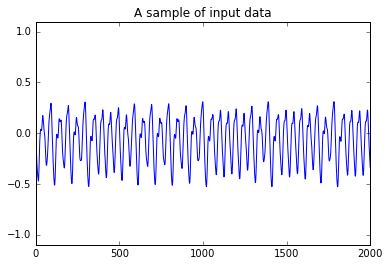

In [19]:
def plot_figure(f) :
    plt.figure(0).clear()
    plt.plot(nw.data[0:int(f)])
    plt.ylim([-1.1,1.1])
    plt.title('A sample of input data')
    
interact(plot_figure, f=FloatSlider(value=2000,min=1000,max=10000,step=1000,continuous_update=False,description='time steps'))

## Processing the network with the parameters

We first randomly generate <b style="color:#99cc00">W<sub>in</sub></b> input weights, and <b style="color:#ffcc00">W</b> reservoir weights. Then, we create the matrices <b style="color:#ffcc00">x</b>, <b style="color:#a7008a">Y<sub>target</sub></b> and <b style="color:#00baff">X</b>.

In [20]:
def initialization(nw) :

    #Weights
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    
    #Matrices
    #Allocated memory for the design (collected states) matrix
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    #Set the corresponding target matrix directly
    nw.Ytarget = nw.data[None,nw.initLen+1:nw.trainLen+1]

    #Run the reservoir with the data and collect X
    nw.x = np.zeros((nw.resSize,1))  
    
    return(nw)

We compute <b style="color:#ffcc00">W</b> (reservoir weights) spectral radius (i.e., the biggest of the absolute eigenvalues). This number will then be used to scale the weights : the biggest the spectral radius is, the easiest it will be for the system to remember longer inputs.

In [21]:
def compute_spectral_radius(nw):
    print('Computing spectral radius...',end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    print('Done.')
    nw.W *= nw.spectral_radius / rhoW
    
    return(nw)

<p style="text-align:justify">We continue with a training phase, which duration depends of the <b>trainLen</b> value. Data from the <i>data</i> file are used in input. The algorithm changes every reservoir neuron value on every step, depending on the <b style="color:#99cc00">W<sub>in</sub></b>. weights, using the following formula :</p></br></br>


$$x_{n} = (1-\alpha)x_{n-1} \times \alpha \tanh(W_{in}.u_{n-1}) + W.x_{n-1}$$


<p style="text-align:justify">In this formula, the $\alpha$ acts as a "memory" factor for the network.
Once the initialization span (<b>initLen</b>) is over, the algorithm begins to modify the X matrix, which collects neurons states during the simulation : the first neuron is the bias (1), the second one is the input, and every other are the x matrix :</p>
$$X_{n} = [1;u_{n};x_{n}]$$

In [22]:
def learning_phase(nw) :
    for t in range(nw.trainLen):
        #Input data
        nw.u = nw.data[t]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot( nw.W, nw.x ) )
        #After the initialization, we start modifying X
        if t >= nw.initLen:
            nw.X[:,t-nw.initLen] = np.vstack((1,nw.u,nw.x))[:,0]
            
    return(nw)

Now, we record output weights <b style="color:#ff0000">W<sub>out</sub></b>, and we correct those according to the reservoir's neurons values (<b style="color:#00baff">X</b>) and the target values (<b style="color:#a7008a">Y<sub>target</sub></b>) :


$$W_{out} = (Y_{t}.X^{T}).(X.X^{T} + reg.I)^{-1}$$

In [33]:
def train_output(nw) :
    nw.X_T = nw.X.T
    if nw.reg is not None:
        # Ridge regression (linear regression with regularization)
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        # Pseudo-inverse
        nw.Wout = np.dot(nw.Yt, linalg.pinv(nw.X) )
        
    return(nw)

When the training is over, we launch network testing. In generative mode, at each iteration, we will use the output to generate the next one. In predictive mode, we will use the real data to try to generate the next one.

In [24]:
def test(nw) :
    #Run the trained ESN in a generative mode. no need to initialize here, 
    #because x is initialized with training data and we continue from there.
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data[nw.trainLen]
    for t in range(nw.testLen):
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.vstack((1,nw.u,nw.x)) )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            #Generative mode:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            #Predictive mode:
            nw.u = nw.data[nw.trainLen+t+1] 
        else:
            raise(Exception, "ERROR: 'mode' was not set correctly.")
    
    return(nw)

In [25]:
def compute_error(nw) :
    # Computing MSE for the first errorLen iterations
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return(nw)

In [26]:
def compute_network(nw) :
    nw = initialization(nw)
    nw = compute_spectral_radius(nw)
    nw = learning_phase(nw)
    nw = train_output(nw)
    nw = test(nw)  
    nw = compute_error(nw)
    return(nw)

## Definition of the network parameters

Here, you can modify the network parameters by moving the cursors, then pressing Validate. This will affect every subsequent graph.

In [34]:
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])
var1 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var2 = FloatSlider(value=100, min=0, max=2000, step=1, description='initLen')
var3 = FloatSlider(value=2000, min=0, max=5000, step=1, description='trainLen')
var4 = FloatSlider(value=2000, min=0, max=5000, step=1, description='testLen')
var5 = FloatSlider(value=1.25, min=0, max=10, step=0.05, description='spectral radius')
var6 = FloatSlider(value=0.3, min=0, max=1, step=0.01, description='leak rate')
valid = Button(description='Validate')

def record_values(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    nw.testLen=int(var4.value)
    nw.spectral_radius=float(var5.value)
    nw.a=float(var6.value)
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
    compute_network(nw)
    return(nw)

display(select_mode)
display(var1)
display(var2)
display(var3)
display(var4)
display(var5)
display(var6)
display(valid)

valid.on_click(record_values)

InitLen: 100 TrainLen: 2000 TestLen: 2000
ResSize: 300 Spectral Radius: 1.25 Leak Rate: 0.3
Computing spectral radius... Done.
MSE = 2.48697274934e-08


## Graph 1: Comparison between expected and estimated outputs

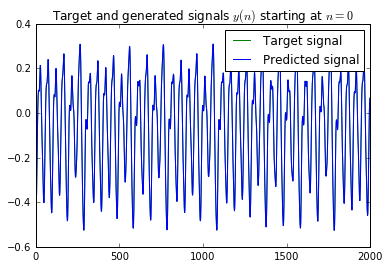

In [35]:
var7 = FloatSlider(value=2000,min=10,max=10000,step=10,description='time steps')
valid = Button(description='Validate')
        
def trace_graph1(_) :
    clear_output()
    f=int(var7.value)
    plt.figure(1).clear()
    plt.plot( nw.data[nw.trainLen+1:nw.trainLen+f+1], 'g' )
    plt.plot( nw.Y.T[0:f], 'b' )
    plt.title('Target and generated signals $y(n)$ starting at $n=0$')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])
    
valid.on_click(trace_graph1)
    
display(var7)
display(valid)

## Graph 2: Difference between expected and estimated outputs

In [29]:
var8 = FloatSlider(value=2000,min=10,max=nw.testLen,step=10,description='time steps')
var9 = FloatSlider(value=0.2,min=0.001,max=10,step=0.001,description='amplitude')
valid = Button(description='Validate')
        
def trace_graph2(_) :
    clear_output()
    f=int(var8.value)
    amp=float(var9.value)
    plt.figure(2).clear()
    plt.ylim([-amp,amp])
    plt.plot(nw.data[nw.trainLen+1:nw.trainLen+f+1]-nw.Y[0][0:f], 'g' )
    print(nw.Y[0].shape)
    plt.title('Target and predicted signal difference through time')
    if nw.mode == 'generative':
        plt.legend(['Target signal', 'Free-running predicted signal'])
    elif nw.mode == 'prediction':
        plt.legend(['Target signal', 'Predicted signal'])
    
valid.on_click(trace_graph2)
    
display(var8)
display(var9)
display(valid)

## Graph 3: Plotting neurons activations (total)

In [30]:
var10 = FloatSlider(value=2000,min=10,max=nw.trainLen-nw.initLen,step=10,description='time steps')
var11 = FloatSlider(value=10, min=1, max=nw.resSize, step=1, description='number of neurons')
valid = Button(description='Validate')

def trace_graph3(_) :
    clear_output()
    f=int(var10.value)
    nb=int(var11.value)
    plt.figure(3).clear()
    plt.plot( nw.X[2:2+nb,0:f].T )
    print(nw.X.shape)
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neurons ID 0 to '+str(nb-1)+' for '+str(f)+' time steps')
    
valid.on_click(trace_graph3)
    
display(var10)
display(var11)
display(valid)

## Graph 4: Plotting single neuron activation

In [31]:
var12 = FloatSlider(value=2000,min=10,max=nw.trainLen-nw.initLen,step=10,description='time steps')
var13 = FloatSlider(value=2, min=0, max=nw.resSize-1, step=1, description='neuron ID')
valid = Button(description='Validate')

def trace_graph4(_) :
    clear_output()
    f=int(var12.value)
    num=int(var13.value)
    plt.figure(4).clear()
    plt.plot( nw.X[2+num,:f].T )
    plt.ylim([-1.1,1.1])
    plt.title('Activations $\mathbf{x}(n)$ from Reservoir Neuron ID '+str(num)+' for '+str(f)+' time steps')

valid.on_click(trace_graph4)

display(var12)
display(var13)
display(valid)

## Graph 5: Output weights at the end of the simulation

In [32]:
valid = Button(description='Show')

def trace_graph5(_) :
    clear_output()
    plt.figure(5).clear()
    plt.bar( range(1+nw.inSize+nw.resSize), nw.Wout.T )
    plt.title('Output weights $\mathbf{W}^{out}$')

valid.on_click(trace_graph5)

display(valid)